## Point Cloud/DEM Alignment [In-progress, please be patient]
#### Adapted from the [ASP Documentation](https://stereopipeline.readthedocs.io/en/latest/tools/pc_align.html#pc-align)

In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
import requests
import numpy as np
import os,sys,glob
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from distutils.spawn import find_executable
import dask
import zipfile
from pyproj import Proj, transform
import subprocess
import asp_binder_utils as asp_utils
import xyzservices
import rioxarray
import rasterio

### Universal settings

In [3]:
verbose = False #  Will only print the bash commands and whether the process ran sucessfully or not
#verbose = True # will print all the logs printed by ASP
alignment_algortihm = 'point-to-plane' # suggested to use point-to-point if the terrain variability is low (more flat terrain cases)
max_displacement = 50 #you might have to play with this to adapt to different datasets



### Download DEMs to perform registration
* For the purpose of this tutorial, we will download Global DEMs from two different sources (SRTM and COPDEM-30) using the Open Topography API.

* We can upload any two DEMs of our choice to perform the co-registration with.
    * To perform this in a github codespace session, go to the file explorer on the right, do a right click and select upload, then upload the DEMs of your choice from the file browser.
    * See also this [stack exhange answer](https://stackoverflow.com/questions/62284623/how-can-i-upload-a-file-to-a-github-codespaces-environment)

* When you change the DEMs to a different site than the site used by default, make sure to change the projected corrdinate system definition (t_srs) 

In [4]:
aoi_fn = './providence_mountains.geojson'
gdf = gpd.read_file(aoi_fn)

In [5]:
terrain_map = xyzservices.providers.Esri.WorldImagery()
gdf.explore(tiles=terrain_map) 


## download [SRTM_E](https://opentopography.org/news/three-new-global-topographic-datasets-available-srtm-ellipsoidal-alos-world-3d-gmrt) (relative to WGS84 ellipsoid) and [AW3D30_E](https://www.eorc.jaxa.jp/ALOS/en/dataset/aw3d30/aw3d30_e.htm)(heights relative to WGS84 ellipsoid) using the Opentopo API

In [7]:
! git clone https://github.com/uw-cryo/opentopo_dem.git

Cloning into 'opentopo_dem'...
remote: Enumerating objects: 38, done.
remote: Counting objects: 100% (38/38), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 38 (delta 19), reused 14 (delta 6), pack-reused 0
Unpacking objects: 100% (38/38), 11.65 KiB | 993.00 KiB/s, done.


In [8]:
srtm_ellipsoidal_fn = 'srtm_providence_mountains.tif'
aw3D30_ellipsoidal_fn = 'aw3D30_providence_mountains.tif'
t_srs = 'EPSG:32611' #will change if you change the data product
tr = 30 #will change if you change the data product

In [9]:
! opentopo_dem/download_global_DEM.py -demtype SRTMGL1_E -poly_fn $aoi_fn -out_fn $srtm_ellipsoidal_fn -out_proj $t_srs 

[-116.48587141088018, 33.59766751364852, -114.62857444034678, 35.082632314855246]
Script is complete


In [10]:
! opentopo_dem/download_global_DEM.py -demtype AW3D30_E -poly_fn $aoi_fn -out_fn $aw3D30_ellipsoidal_fn -out_proj $t_srs

[-116.48587141088018, 33.59766751364852, -114.62857444034678, 35.082632314855246]
Script is complete


In [15]:
pc_align = find_executable('pc_align')
refdem = os.path.splitext(srtm_ellipsoidal_fn)[0]+"_proj.tif"
src_dem = os.path.splitext(aw3D30_ellipsoidal_fn)[0]+"_proj.tif"
alignment_dir  = 'alignment/run'
alignment_call = f'{pc_align} --highest-accuracy  --save-transformed-source-points --alignment-method {alignment_algortihm}  --max-displacement {max_displacement} {refdem} {src_dem} -o {alignment_dir}'
if verbose:
    ! alignment_call
else:
    asp_utils.run_bash_command(alignment_call)

/srv/StereoPipeline/bin/pc_align --highest-accuracy  --save-transformed-source-points --alignment-method point-to-plane  --max-displacement 50 srtm_providence_mountains_proj.tif aw3D30_providence_mountains_proj.tif -o alignment/run
	--> Setting number of processing threads to: 4
Writing log info to: alignment/run-log-pc_align-11-07-2103-3244.txt
Detected datum from srtm_providence_mountains_proj.tif:
Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Will use datum (for CSV files): Geodetic Datum --> Name: WGS_1984  Spheroid: WGS 84  Semi-major axis: 6378137  Semi-minor axis: 6356752.3142451793  Meridian: Greenwich at 0  Proj4 Str: +datum=WGS84
Computing the intersection of the bounding boxes of the reference and source points using 9000000 sample points.
Reference box: (Origin: (-116.487, 33.5969) width: 1.85877 height: 1.48652)
Source box:    (Origin: (-116.487, 33.597) 

writing to alignment/run-iterationInfo.csv


Match ratio: 0.75001
Alignment took 59.0737 [s]
Number of errors: 100000
Output: error percentile of smallest errors (meters): 16%: 0.461576, 50%: 1.5823, 84%: 3.9257
Output: mean of smallest errors (meters): 25%: 0.360926, 50%: 0.749708, 75%: 1.22755, 100%: 2.33861
Final error computation took 0.218702 [s]
Alignment transform (origin is planet center):
    0.9999999999824201 -5.807906703072115e-06 -1.195018330912938e-06     -16.64152603875846
 5.807894445744579e-06     0.9999999999304695 -1.026828053774445e-05       39.4034481914714
  1.19507795655324e-06  1.026827357372096e-05     0.9999999999465127      40.46964778238907
                     0                      0                      0                      1
Centroid of source points (Cartesian, meters): Vector3(-2274746.4,-4756156.2,3577907.3)
Centroid of source points (lat,lon,z): Vector3(34.341568,-115.56058,200.25878)

Translation vector (Cartesian, meters): Vector3(6.7061609,-10.546664,-11.086556)
Translation vector (North-E

Child returned 0


In [27]:
### Tada: we have the aligned pointcloud. Note the log printed above for some important observations, such as: input and output error statistics, Translation vector (North-East-Down, meter) etc
## The output is in ASP 4-band point cloud tiff file. We will need to re-grid it to generate the aligned source DEM.
point2dem = find_executable('point2dem')
tr = tr
tsrs = t_srs
#p2dem_args = '--errorimage'
pointcloud = glob.glob(alignment_dir+'*-trans_source.tif')[0]
print ("Gridding pointcloud {} at {} m/px".format(pointcloud,tr))
point2dem_call  = f"{point2dem} --tr {tr} --t_srs '{tsrs}' {pointcloud}"
if verbose:
    ! $point2dem_call
else:
    asp_utils.run_bash_command(point2dem_call)
aligned_dem = glob.glob(alignment_dir+'*-DEM.tif')[0]
print("DEM saved at {}".format(dem))


Gridding pointcloud alignment/run-trans_source.tif at 30 m/px
/srv/StereoPipeline/bin/point2dem --tr 30 --t_srs 'EPSG:32611' alignment/run-trans_source.tif
	--> Setting number of processing threads to: 4
Writing log info to: alignment/run-trans_source-log-point2dem-11-07-2146-19101.txt
The point cloud files must have an equal number of channels which must be 4 or 6 to be able to remove outliers.
Statistics: [********************************************************] Complete!
QuadTree: [**********************************************************] Complete!
	-- Starting DEM rasterization --
	--> DEM spacing: 30 pt/px
	             or: 0.0333333 px/pt
Creating output file that is Vector2(5773,5571) px.
Writing: alignment/run-trans_source-DEM.tif
DEM: [***************************************************************] Complete!
Percentage of valid pixels: 97.2585%
DEM saved at alignment/run-trans_source-DEM.tif


Child returned 0


In [21]:
## Visualize the change before and after DEM alignment
refdem_ar = rioxarray.open_rasterio(refdem)
src_dem_ar = rioxarray.open_rasterio(src_dem)
aligned_dem_ar = rioxarray.open_rasterio(aligned_dem)

/srv/conda/envs/notebook/lib/python3.8/site-packages/matplotlib/colors.py:718: RuntimeWarning: overflow encountered in multiply
  xa *= self.N


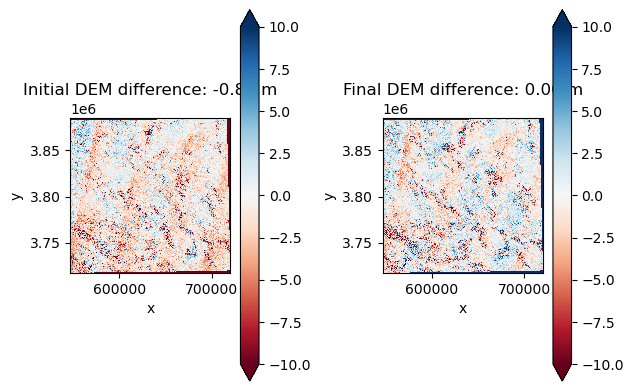

In [28]:
diff = refdem_ar - src_dem_ar.rio.reproject_match(refdem_ar,resampling=rasterio.enums.Resampling.bilinear)
aligned_diff = refdem_ar - aligned_dem_ar.rio.reproject_match(refdem_ar,resampling=rasterio.enums.Resampling.bilinear)
f,ax = plt.subplots(1,2)
diff.plot(vmin=-10, vmax=10, cmap="RdBu",ax=ax[0])
ax[0].set_title(f"Initial DEM difference: {diff.median().item():.2f} m")
aligned_diff.plot(vmin=-10, vmax=10, cmap="RdBu",ax=ax[1])
ax[1].set_title(f"Final DEM difference: {aligned_diff.median().item():.2f} m")
plt.tight_layout()
for axa in ax.ravel():
    axa.set_aspect('equal')

## Additional things to keep in mind: 
* Higher resolution DEM/point cloud should be treated as reference in the pc_align call.
* Max displacement should be chosen carefully